In [1]:
import numpy as np
import time
import os
import cv2
import sys

# Now cluster the data

%pylab inline
import os
import cv2
import time
import pandas as pd
import tqdm


Populating the interactive namespace from numpy and matplotlib


In [2]:

start_time = time.time()

def load():
    image_dir = 'square'
    images_full_dir = os.listdir(image_dir)
    #print(images_full_dir)
    images_full_dir.sort()
    #print(images_full_dir)
    
    img_table = np.ndarray((len(images_full_dir)-1, 40, 80, 3), dtype = np.uint8)

    # fill in image matrix with images
    for i in range(1, len(images_full_dir)):
        if 'square' not in images_full_dir[i]:
            continue
        file_name = os.path.join(image_dir, images_full_dir[i])
        #print(file_name)
        if i == 1:
            print(file_name)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_table[i-1,:,:,:] = cv2.imread(file_name, cv2.IMREAD_COLOR)

    return img_table

img_table = load()
print("Total time to load small data is", time.time() - start_time, "seconds")

square/square0.png
Total time to load small data is 0.18302631378173828 seconds


In [3]:
n,h,w,c = img_table.shape
X_train = img_table[:int(n*0.8),:,:,:]
X_test = img_table[int(n*0.8):,:,:,:]


X_train_norm = np.copy(X_train) / 255.0
X_test_norm = np.copy(X_test) / 255.0


In [4]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import gc
gc.collect()


torch.cuda.empty_cache() 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)

In [5]:
## I want to try u-net as an autoencoder (w-net as an autoencoder doesn't work)



# Writing our model
class unet_seg(nn.Module):
    def __init__(self):
        super(unet_seg,self).__init__()
        
        self.K = 10
        self.output_channels = 3
        self.input_channels = 3
        
        self.create_enc()
        
        
    def forward(self,x):
        x1 = self.u_enc1(x)
        x2 = self.u_enc2(x1)
        x3 = self.u_enc3(x2)
        x4 = self.u_enc4(x3)
        x34 = torch.cat([x3,x4], dim = 1)
        x5 = self.u_enc5( x34 )
        x25 = torch.cat([x2,x5], dim = 1)
        x6 = self.u_enc6( x25 )
        x16 = torch.cat([x1,x6], dim = 1)
        x7 = self.u_enc7( x16 ) #reconstructed
        x8 = self.u_enc_seg( x16 ) #segmented
        
        return [x7,x8]
    
    
    def create_enc(self):
        self.u_enc1 = nn.Sequential()
        self.u_enc1.add_module('Conv1_1', nn.Conv2d(self.input_channels, 16, kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_2', nn.ReLU(True))
        self.u_enc1.add_module('Conv1_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_4', nn.ReLU(True))
        
        self.u_enc2 = nn.Sequential()
        self.u_enc2.add_module('Max2_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc2.add_module('Conv2_2', nn.Conv2d(16, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_3', nn.ReLU(True))
        self.u_enc2.add_module('Conv2_4', nn.Conv2d(32, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_5', nn.ReLU(True))
        
        self.u_enc3 = nn.Sequential()
        self.u_enc3.add_module('Max3_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc3.add_module('Conv3_2', nn.Conv2d(32, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_3', nn.ReLU(True))
        self.u_enc3.add_module('Conv3_4', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_5', nn.ReLU(True))
        
        self.u_enc4 = nn.Sequential()
        self.u_enc4.add_module('Max4_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc4.add_module('Conv4_2', nn.Conv2d(64, 128, kernel_size=3, padding = (1,1)))
        self.u_enc4.add_module('Relu4_3', nn.ReLU(True))
        self.u_enc4.add_module('Conv4_4', nn.Conv2d(128, 128, kernel_size=3, padding = (1,1)))
        self.u_enc4.add_module('Relu4_5', nn.ReLU(True))
        self.u_enc4.add_module('CT4_6', nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2))
        
        self.u_enc5 = nn.Sequential()
        self.u_enc5.add_module('Conv5_1', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_enc5.add_module('Relu5_2', nn.ReLU(True))
        self.u_enc5.add_module('Conv5_3', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_enc5.add_module('Relu5_4', nn.ReLU(True))
        self.u_enc5.add_module('CT5_5', nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2))
        
        self.u_enc6 = nn.Sequential()
        self.u_enc6.add_module('Conv6_1', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_enc6.add_module('Relu6_2', nn.ReLU(True))
        self.u_enc6.add_module('Conv6_3', nn.Conv2d(32, 32, kernel_size=3, padding = (1,1)))
        self.u_enc6.add_module('Relu6_4', nn.ReLU(True))
        self.u_enc6.add_module('CT6_5', nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2))
        
        self.u_enc7 = nn.Sequential()
        self.u_enc7.add_module('Conv7_1', nn.Conv2d(32, 16, kernel_size=3, padding = (1,1)))
        self.u_enc7.add_module('Relu7_2', nn.ReLU(True))
        self.u_enc7.add_module('Conv7_3', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.u_enc7.add_module('Relu7_4', nn.ReLU(True))
        self.u_enc7.add_module("Conv7_5", nn.Conv2d(16, self.output_channels, kernel_size = 1))
        self.u_enc7.add_module('Relu7_6', nn.ReLU(True))
        
        self.u_enc_seg = nn.Sequential()
        self.u_enc_seg.add_module('Conv8_1', nn.Conv2d(32,16, kernel_size=3, padding = (1,1)))
        self.u_enc_seg.add_module('Relu8_2', nn.ReLU(True))
        self.u_enc_seg.add_module('Conv8_3', nn.Conv2d(16, 16, kernel_size=3, padding = (1,1)))
        self.u_enc_seg.add_module('Relu8_4', nn.ReLU(True))
        self.u_enc_seg.add_module('Conv8_5', nn.Conv2d(16, self.K, kernel_size = 1))
        self.u_enc_seg.add_module('Soft8_6', nn.Softmax())
        

In [6]:
model = unet_seg().cuda()
distance = nn.MSELoss()

# Loss Function Revision

batch_size = 512
n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

#dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)

In [7]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
total_epochs = 300



optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
for epoch in range(total_epochs):
 #   if epoch % 1000 == 0:
 #       optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        recon, seg = model(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        
        loss2 = distance(recon, images_cuda)
        loss2.backward()
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")

    print('epoch [{}/{}], loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss2.data, time.perf_counter() - st))


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch [1/300], loss2:0.0973, time elapsed:1.0007 (sec)
epoch [2/300], loss2:0.0934, time elapsed:0.7873 (sec)
epoch [3/300], loss2:0.0940, time elapsed:0.7651 (sec)
epoch [4/300], loss2:0.0934, time elapsed:0.7540 (sec)
epoch [5/300], loss2:0.0925, time elapsed:0.7773 (sec)
epoch [6/300], loss2:0.0936, time elapsed:0.7690 (sec)
epoch [7/300], loss2:0.0914, time elapsed:0.8005 (sec)
epoch [8/300], loss2:0.0897, time elapsed:0.7873 (sec)
epoch [9/300], loss2:0.0868, time elapsed:0.7868 (sec)
epoch [10/300], loss2:0.0917, time elapsed:0.7144 (sec)
epoch [11/300], loss2:0.0891, time elapsed:0.7891 (sec)
epoch [12/300], loss2:0.0877, time elapsed:0.7333 (sec)
epoch [13/300], loss2:0.0881, time elapsed:0.7236 (sec)
epoch [14/300], loss2:0.0862, time elapsed:0.7950 (sec)
epoch [15/300], loss2:0.0862, time elapsed:0.7818 (sec)
epoch [16/300], loss2:0.0844, time elapsed:0.7437 (sec)
epoch [17/300], loss2:0.0842, time elapsed:0.7882 (sec)
epoch [18/300], loss2:0.0805, time elapsed:0.7758 (sec)
e

In [8]:
X_test_torch = torch.from_numpy(X_test_norm[0:10]).float()
test_data = X_test_torch.permute(0,3,1,2)
test_cuda = test_data.cuda()
recon, seged = model(test_cuda)

In [9]:
recon_p = recon.permute(0,2,3,1)
print(recon_p.size())

recon_imgs = recon_p.detach().cpu().numpy()
recon_imgs *= 255
recon_imgs = recon_imgs.astype(np.uint8)

torch.Size([10, 40, 80, 3])


In [10]:
# Try to visualize segmented image

print(torch.max(seged))
print(torch.min(seged))

N,K,H,W = seged.size()

arged = torch.argmax(seged, dim = 1) #channels is 1
arged = arged * 255 / (K - 1)
arged_imgs = arged.detach().cpu().numpy()

print(recon_p.size())

arged_imgs = arged_imgs.astype(np.uint8)


tensor(0.1471, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0685, device='cuda:0', grad_fn=<MinBackward1>)
torch.Size([10, 40, 80, 3])


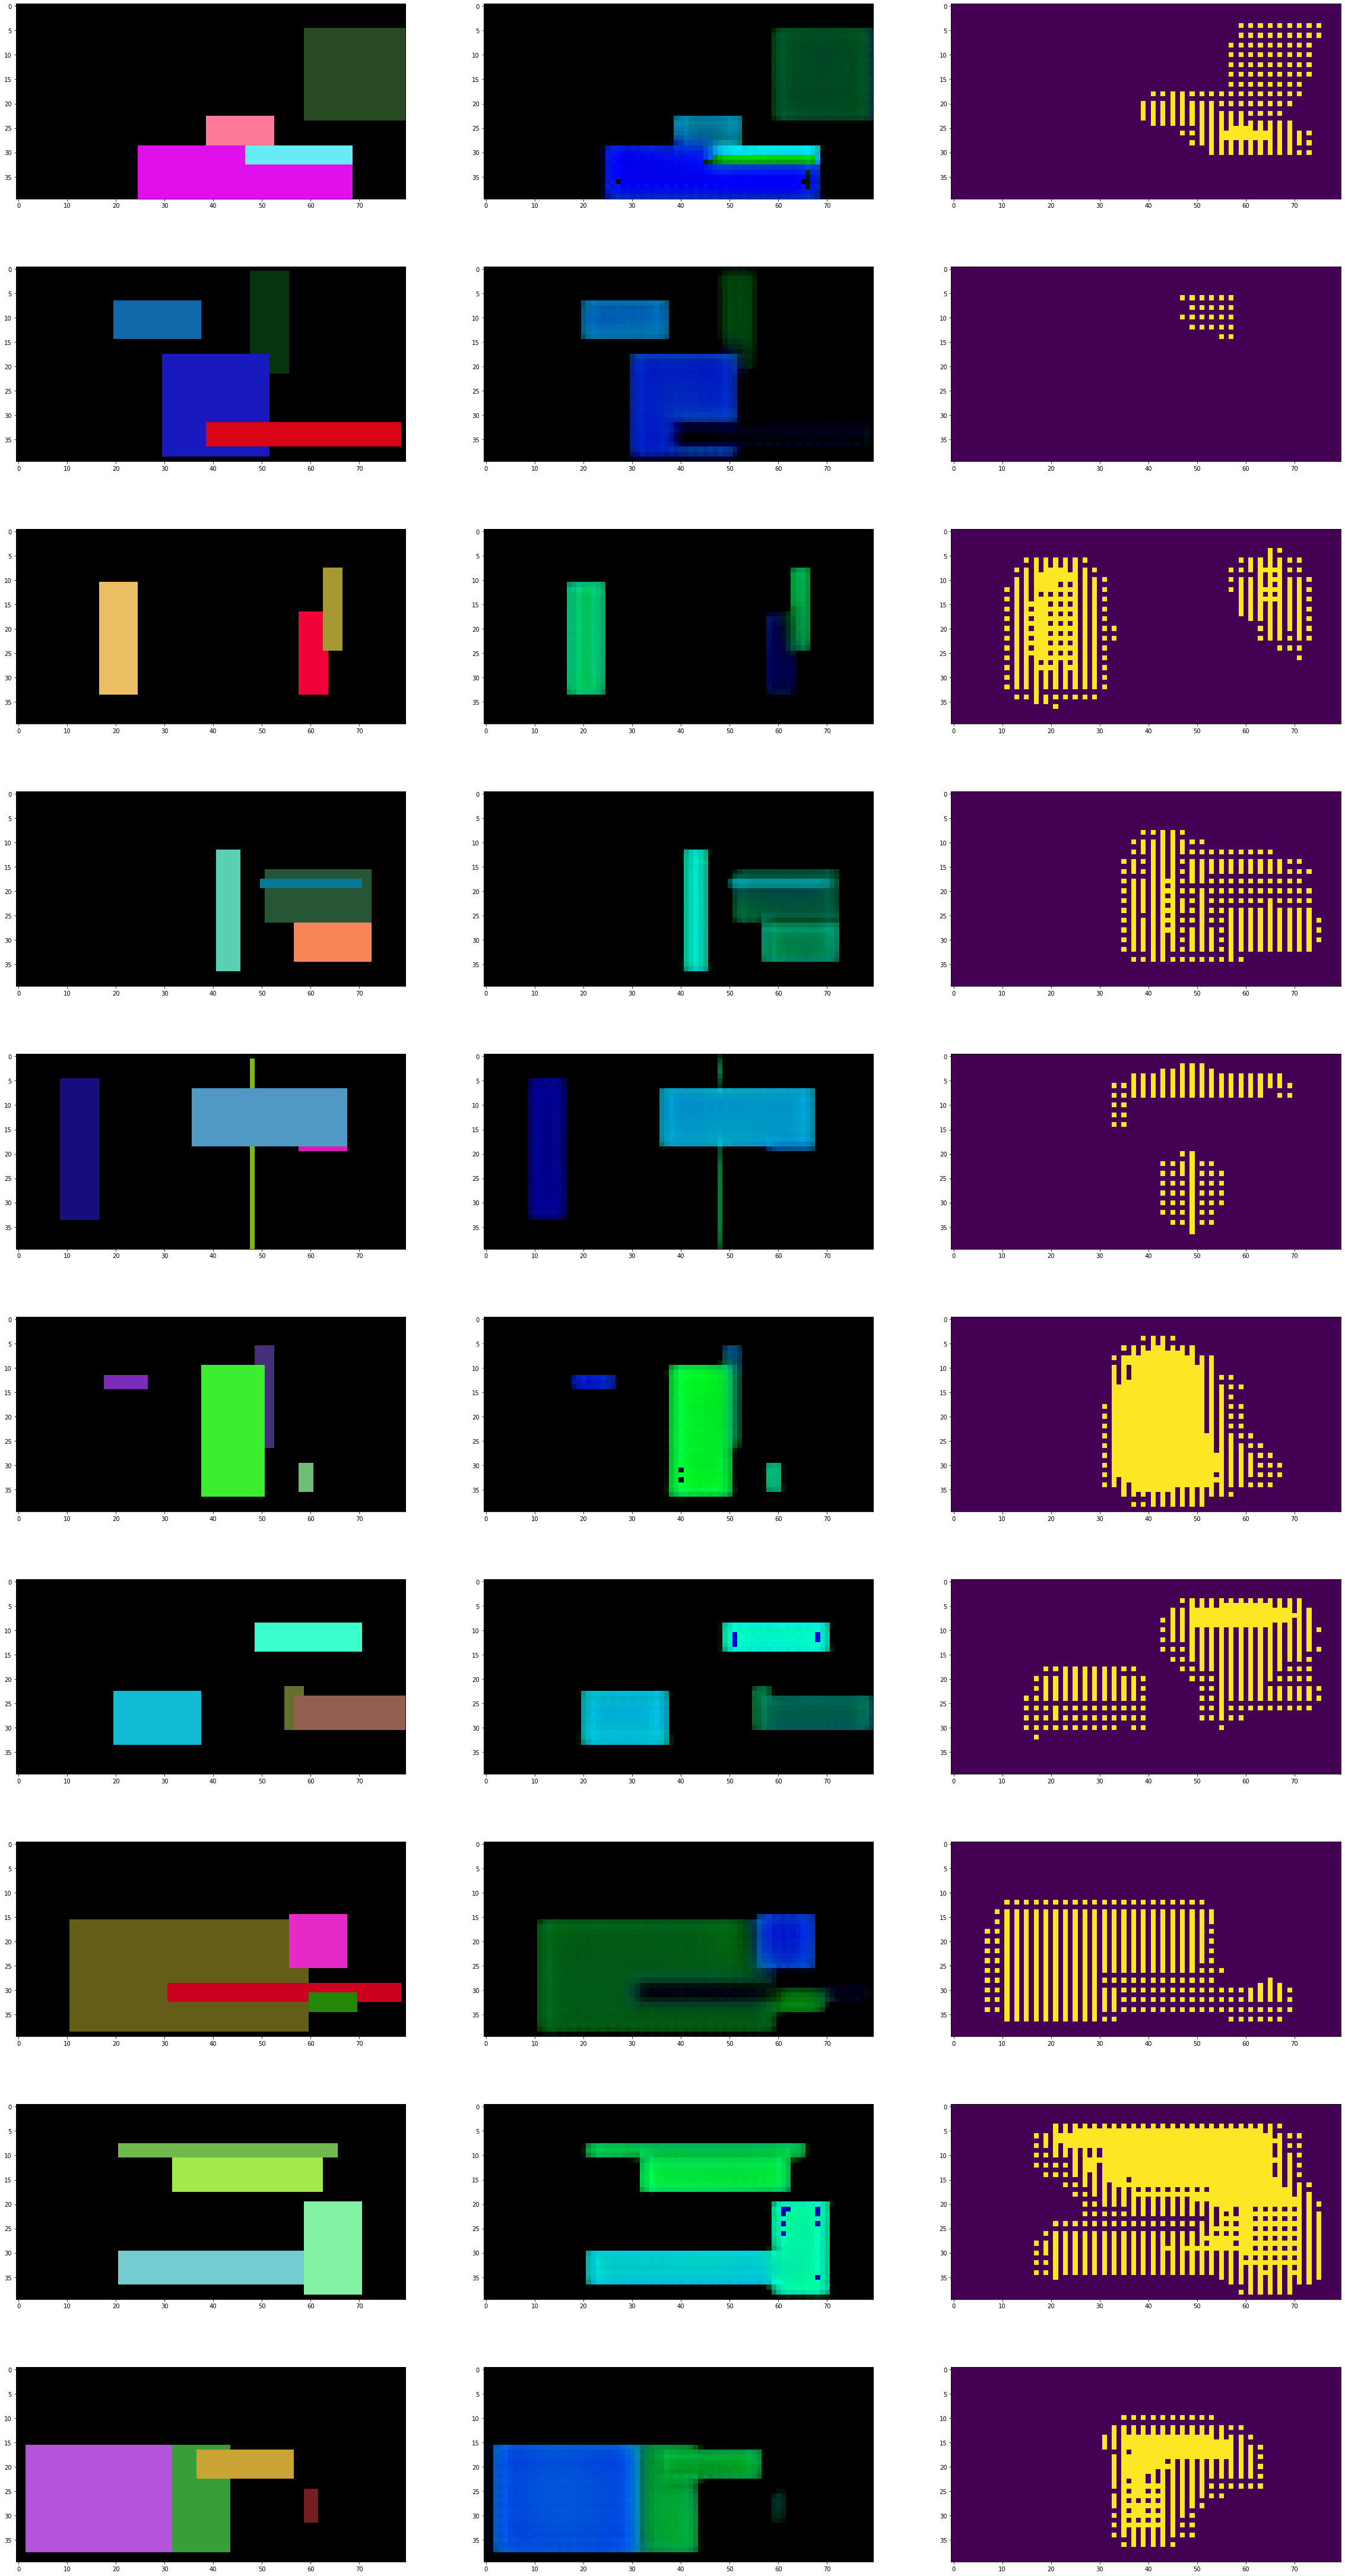

In [11]:

fig = plt.figure(figsize=(40,80))
columns = 3
rows = 10
for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows,columns,i*columns + j + 1)
        if j == 0:     
            plt.imshow(X_test[i,:,:,:])
        if j == 1:
            plt.imshow(recon_imgs[i])
        if j == 2:
            plt.imshow(arged_imgs[i])
    
plt.show()

In [12]:
## freezing parameter that are unrelated to segmentation, essentially, we only want to train the last few layers
model_dict = dict(model.named_parameters())


for (param, value) in model_dict.items():
    #print(param)
    if 'seg' in param:
        continue
    value.requires_grad = False
    

In [19]:
#import custom loss function, let's see how well things are trained

# Create custom loss function

def calculate_denom(segmented_imgs, weight_matrix):
    # segmented_imgs: torch.Size(N,K,H,W)
    # weight_matrix: torch.Size(N,H,W,HxW)
    # steps:
    # 1. create the expanded matrix
    # 2. multiply with weight_matrix
    # 3. tensor sum wrt depth
    # 4. tensor sum wrt h,w
    # 5. should be a number
    #seg = segmented_imgs
    #seg = torch.tensor(segmented_imgs.data.clone(), requires_grad = True)
    seg = segmented_imgs.clone()
    N,K,H,W = seg.size()
    seg.unsqueeze_(-1)
    seg = seg.expand(-1, -1, -1,-1,H*W)
    assert(seg.size() == torch.Size([N,K,H,W,H*W]))
    assert(weight_matrix.size() == torch.Size([N,K,H,W,H*W]))
    seg = torch.mul(seg, weight_matrix)
    return seg.sum((2,3,4))

def calculate_num(segmented_imgs, weight_matrix):
    # segmented_imgs: torch.Size(N,K,H,W)
    # weight_matrix will be of size (N,H,W,HxW)
    
    N,K,H,W = segmented_imgs.size()
    #seg1 = torch.tensor(segmented_imgs.data.clone(), requires_grad = True)
    #seg2 = torch.tensor(seg1.clone(), requires_grad = True)
    seg1 = segmented_imgs.clone()
    seg2 = segmented_imgs.clone()
    
    seg1.unsqueeze_(-1) # N,K,H,W,1
    seg1 = seg1.expand(-1, -1, -1, -1, H*W)
    seg2.unsqueeze_(-1) # N,K,H,W,1
    seg2 = seg2.reshape(N,K, 1, 1, -1) # N,K,1,1,H*W
    seg2 = seg2.expand(-1,-1, H, W, -1) # N,K,H,W,H*W
    assert(seg1.size() == seg2.size())
    seg1 = torch.mul(seg1, seg2) # N,K,H,W,H*W
    
    seg1 = torch.mul(seg1, weight_matrix) #N,K,H,W,H*W
    return seg1.sum((2,3,4))

def calculate_dist_matrix(N, H, W):
    
    sigma_x_squared = 0.16
    threshold = 3
    #x_matrix1 = torch.arange(end = H, dtype=torch.float, requires_grad=True).cuda()
    x_matrix1 = torch.arange(end = H, dtype=torch.float).cuda()
    
    x_matrix1.unsqueeze_(-1)
    x_matrix1 = x_matrix1.expand(-1, W)
    x_matrix1.unsqueeze_(-1)
    x_matrix1 = x_matrix1.expand(-1,-1,H*W)
    
    #x_matrix2 = torch.arange(end = H, dtype = torch.float, requires_grad = True).cuda()
    x_matrix2 = torch.arange(end = H, dtype = torch.float).cuda()
    x_matrix2.unsqueeze_(-1)
    x_matrix2 = x_matrix2.expand(-1,W)
    x_matrix2.unsqueeze_(-1)
    x_matrix2 = x_matrix2.reshape(1,1,-1)
    x_matrix2 = x_matrix2.expand(H,W,-1)
    
    x_matrix1 = x_matrix1 - x_matrix2
    x_matrix_final = torch.pow(x_matrix1, 2)
    
    #y_matrix1 = torch.arange(end = W, dtype=torch.float, requires_grad=True ).cuda()
    y_matrix1 = torch.arange(end = W, dtype=torch.float).cuda()
    y_matrix1.unsqueeze_(-1)
    y_matrix1 = y_matrix1.expand(-1, H)
    y_matrix1 = y_matrix1.permute(1,0)
    y_matrix1.unsqueeze_(-1)
    y_matrix1 = y_matrix1.expand(-1,-1,H*W)
    
    #y_matrix2 = torch.arange(end = W, dtype = torch.float, requires_grad = True).cuda()
    y_matrix2 = torch.arange(end = W, dtype = torch.float).cuda()
    y_matrix2 = y_matrix2.repeat(H)
    y_matrix2.unsqueeze_(-1)
    y_matrix2.unsqueeze_(-1)
    y_matrix2 = y_matrix2.permute(1,2,0)
    y_matrix2 = y_matrix2.expand(H,W,-1)
    
    y_matrix1 = y_matrix1 - y_matrix2
    y_matrix_final = torch.pow(y_matrix1,2)
    
    dist_diff = torch.exp( -torch.div(x_matrix_final+y_matrix_final, sigma_x_squared) )
    threshold_matrix = x_matrix1 + y_matrix1
    threshold_matrix[threshold_matrix < threshold] = 1
    threshold_matrix[threshold_matrix >= threshold] = 0
    dist_diff = torch.mul(dist_diff, threshold_matrix)
    
    assert(dist_diff.size() == torch.Size([H,W,H*W]))
    dist_diff.unsqueeze_(0)
    dist_diff = dist_diff.expand(N,-1, -1, -1) #N,H,W,H*W

    return dist_diff

def create_weight_matrix(N, H, W, K, dist_diff, original_img):
    # given the corresponding height and width, will create a weight matrix of size H,W,HxW according to the formula given in
    # w-net paper.
    # original_img size: torch.Size(N,C,H,W)
    # dist_diff size: torch.Size(N,H,W,H*W)
    # we will assume matrix of size H, W is given, it is initialized to zeros
    
    sigma_i_squared = 10
     
    #matrix1 = original_img
    #matrix1 = torch.tensor(original_img.clone(), requires_grad = True)
    matrix1 = original_img.clone()
    matrix1.unsqueeze_(-1)
    matrix1 = matrix1.expand(-1,-1,-1,-1,H*W)
    assert(matrix1.size() == torch.Size([N,C,H,W,H*W]))
    
    #matrix2 = torch.tensor(original_img.clone(), requires_grad = True)
    #matrix2 = original_img
    matrix2 = original_img.clone()
    matrix2.unsqueeze_(-1)
    matrix2 = matrix2.reshape(N,C,1,1,-1) #N,C,1,1,H*W
    matrix2 = matrix2.expand(-1,-1,H,W,-1) #N,C,H,W,H*W
    assert(matrix2.size() == torch.Size([N,C,H,W,H*W]))
    matrix1 = matrix1 - matrix2
    matrix1 = torch.pow(matrix1,2) #N,C,H,W,H*W
    
    matrix1 = torch.exp( -torch.div( matrix1.sum(1), sigma_i_squared) ) #N,H,W,H*W
    weight = torch.pow(matrix1, 2) #N,H,W,H*W
    assert(weight.size() == torch.Size([N,H,W,H*W]))
    weight.unsqueeze_(1)
    weight = weight.expand(-1,K,-1,-1,-1) #N,K,H,W,H*W
    
    return weight
    
    
#TODO: Need to convert this to 4d matrix because we expect to pass in multiple samples
def softcut_loss(segmented_imgs, original_imgs, dist_diff_matrix):
    N,K,H,W = segmented_imgs.size()
    loss = 0
    wt = 0
    nt = 0
    dt = 0
    
    weight_matrix = create_weight_matrix(N, H, W, K, dist_diff_matrix, original_imgs)
    
    num = calculate_num(segmented_imgs, weight_matrix)
    denom = calculate_denom(segmented_imgs, weight_matrix)
    
    # returned num, denom is torch.Size([N,K])
    
    total_sum = torch.sum(torch.div(num, denom))
    return N*K - total_sum
    
    
    ### Before batch processing
    """
    for i in range(N):
        segmented_img = segmented_imgs[i,:,:,:]
        original_img = original_imgs[i,:,:,:]
        weight_matrix = create_weight_matrix(N,H,W, dist_diff_matrix, original_img)
        
        frac_sum = 0
        
        #used for profiling
        num_time = 0
        denom_time = 0
        for j in range(K):
            num = calculate_num(segmented_img[j,:,:], weight_matrix)
            
            denom = calculate_denom(segmented_img[j,:,:], weight_matrix)
            frac_sum += num / denom
            
    return K - frac_sum
    """
    ### End
        


In [20]:
num_epochs = 100
batch_size = 16


n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)

In [21]:

num_epochs = 20
for epoch in range(num_epochs):
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        recon, seg = model(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        loss1 = softcut_loss(seg, images_cuda, dist_diff_matrix)
        loss1.backward(retain_graph = True)
        #print_grad("After back prop") ##
        optimizer.step()
        #print_grad("After application")
        optimizer.zero_grad()
        #print_grad("After 2nd zero grad")
        
        #loss2 = distance(recon, images_cuda)
        #loss2.backward()
        #print_grad("After 2nd loss backward")
        #optimizer.step()
        #print_grad("After 2nd grad application")
        
    #print('epoch [{}/{}], loss1:{:.4f}, loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, loss2.data, time.perf_counter() - st))
    print('epoch [{}/{}], loss1:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, time.perf_counter() - st))


epoch [1/20], loss1:142.9019, time elapsed:39.0189 (sec)
epoch [2/20], loss1:142.8444, time elapsed:38.9878 (sec)
epoch [3/20], loss1:142.7361, time elapsed:38.9804 (sec)
epoch [4/20], loss1:142.6323, time elapsed:39.0733 (sec)
epoch [5/20], loss1:142.9164, time elapsed:39.0321 (sec)
epoch [6/20], loss1:143.0179, time elapsed:39.0540 (sec)
epoch [7/20], loss1:142.8309, time elapsed:39.0663 (sec)
epoch [8/20], loss1:142.9878, time elapsed:39.0303 (sec)
epoch [9/20], loss1:142.9526, time elapsed:39.0757 (sec)
epoch [10/20], loss1:142.8451, time elapsed:39.0701 (sec)
epoch [11/20], loss1:142.6958, time elapsed:39.0388 (sec)
epoch [12/20], loss1:142.8556, time elapsed:39.0466 (sec)
epoch [13/20], loss1:142.5445, time elapsed:39.0423 (sec)
epoch [14/20], loss1:142.2419, time elapsed:39.0182 (sec)
epoch [15/20], loss1:142.7937, time elapsed:39.0144 (sec)
epoch [16/20], loss1:142.5480, time elapsed:39.0869 (sec)
epoch [17/20], loss1:143.0227, time elapsed:39.0142 (sec)
epoch [18/20], loss1:14

In [22]:
X_test_torch = torch.from_numpy(X_test_norm[0:10]).float()
test_data = X_test_torch.permute(0,3,1,2)
test_cuda = test_data.cuda()
recon, seged = model(test_cuda)

### recon reshaped
recon_p = recon.permute(0,2,3,1)
print(recon_p.size())

recon_imgs = recon_p.detach().cpu().numpy()
recon_imgs *= 255
recon_imgs = recon_imgs.astype(np.uint8)

# Try to visualize segmented image

print(torch.max(seged))
print(torch.min(seged))

### seg reshaped
N,K,H,W = seged.size()
arged = torch.argmax(seged, dim = 1) #channels is 1
arged = arged * 255 / (K - 1)
arged_imgs = arged.detach().cpu().numpy()

print(recon_p.size())

arged_imgs = arged_imgs.astype(np.uint8)


torch.Size([10, 40, 80, 3])
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.6981e-25, device='cuda:0', grad_fn=<MinBackward1>)
torch.Size([10, 40, 80, 3])


In [23]:
arg_tmp = torch.argmax(seged, dim = 1)
arg_tmp_cpu = arg_tmp.detach().cpu().numpy()
n,h,w = arg_tmp_cpu.shape
arg_tmp_reshaped = arg_tmp_cpu.reshape((n,h*w,1))
arg_tmp_reshaped = np.squeeze(arg_tmp_reshaped)
print(arg_tmp_reshaped.shape)
# I want to count for each image how many of each value there is
# Also it seems weird that the max value is 3 - maybe I should do something about distance function
# Also I should try changing the K value?
for i in range(10):
    bins = np.bincount(arg_tmp_reshaped[i,:])
    print(bins)


(10, 3200)
[   0   28   64    0 2286    0    0   63  283  476]
[   0  163    9    0 2448    0    0    0  153  427]
[   0   51  120    0 2855    0    0  125   49]
[   0   35  207    0 2724    0    0   74  160]
[   0  111  294    0 2563    0    0    0   86  146]
[   0   14    3    0 2775    0    0  377   21   10]
[   0   33  394    0 2684    0    0   47   42]
[   0   30    2    0 1952    0    0  789  300  127]
[   0    1  442    0 2346    0    0  401   10]
[   0    9   39    0 2173    0    0  313   31  635]


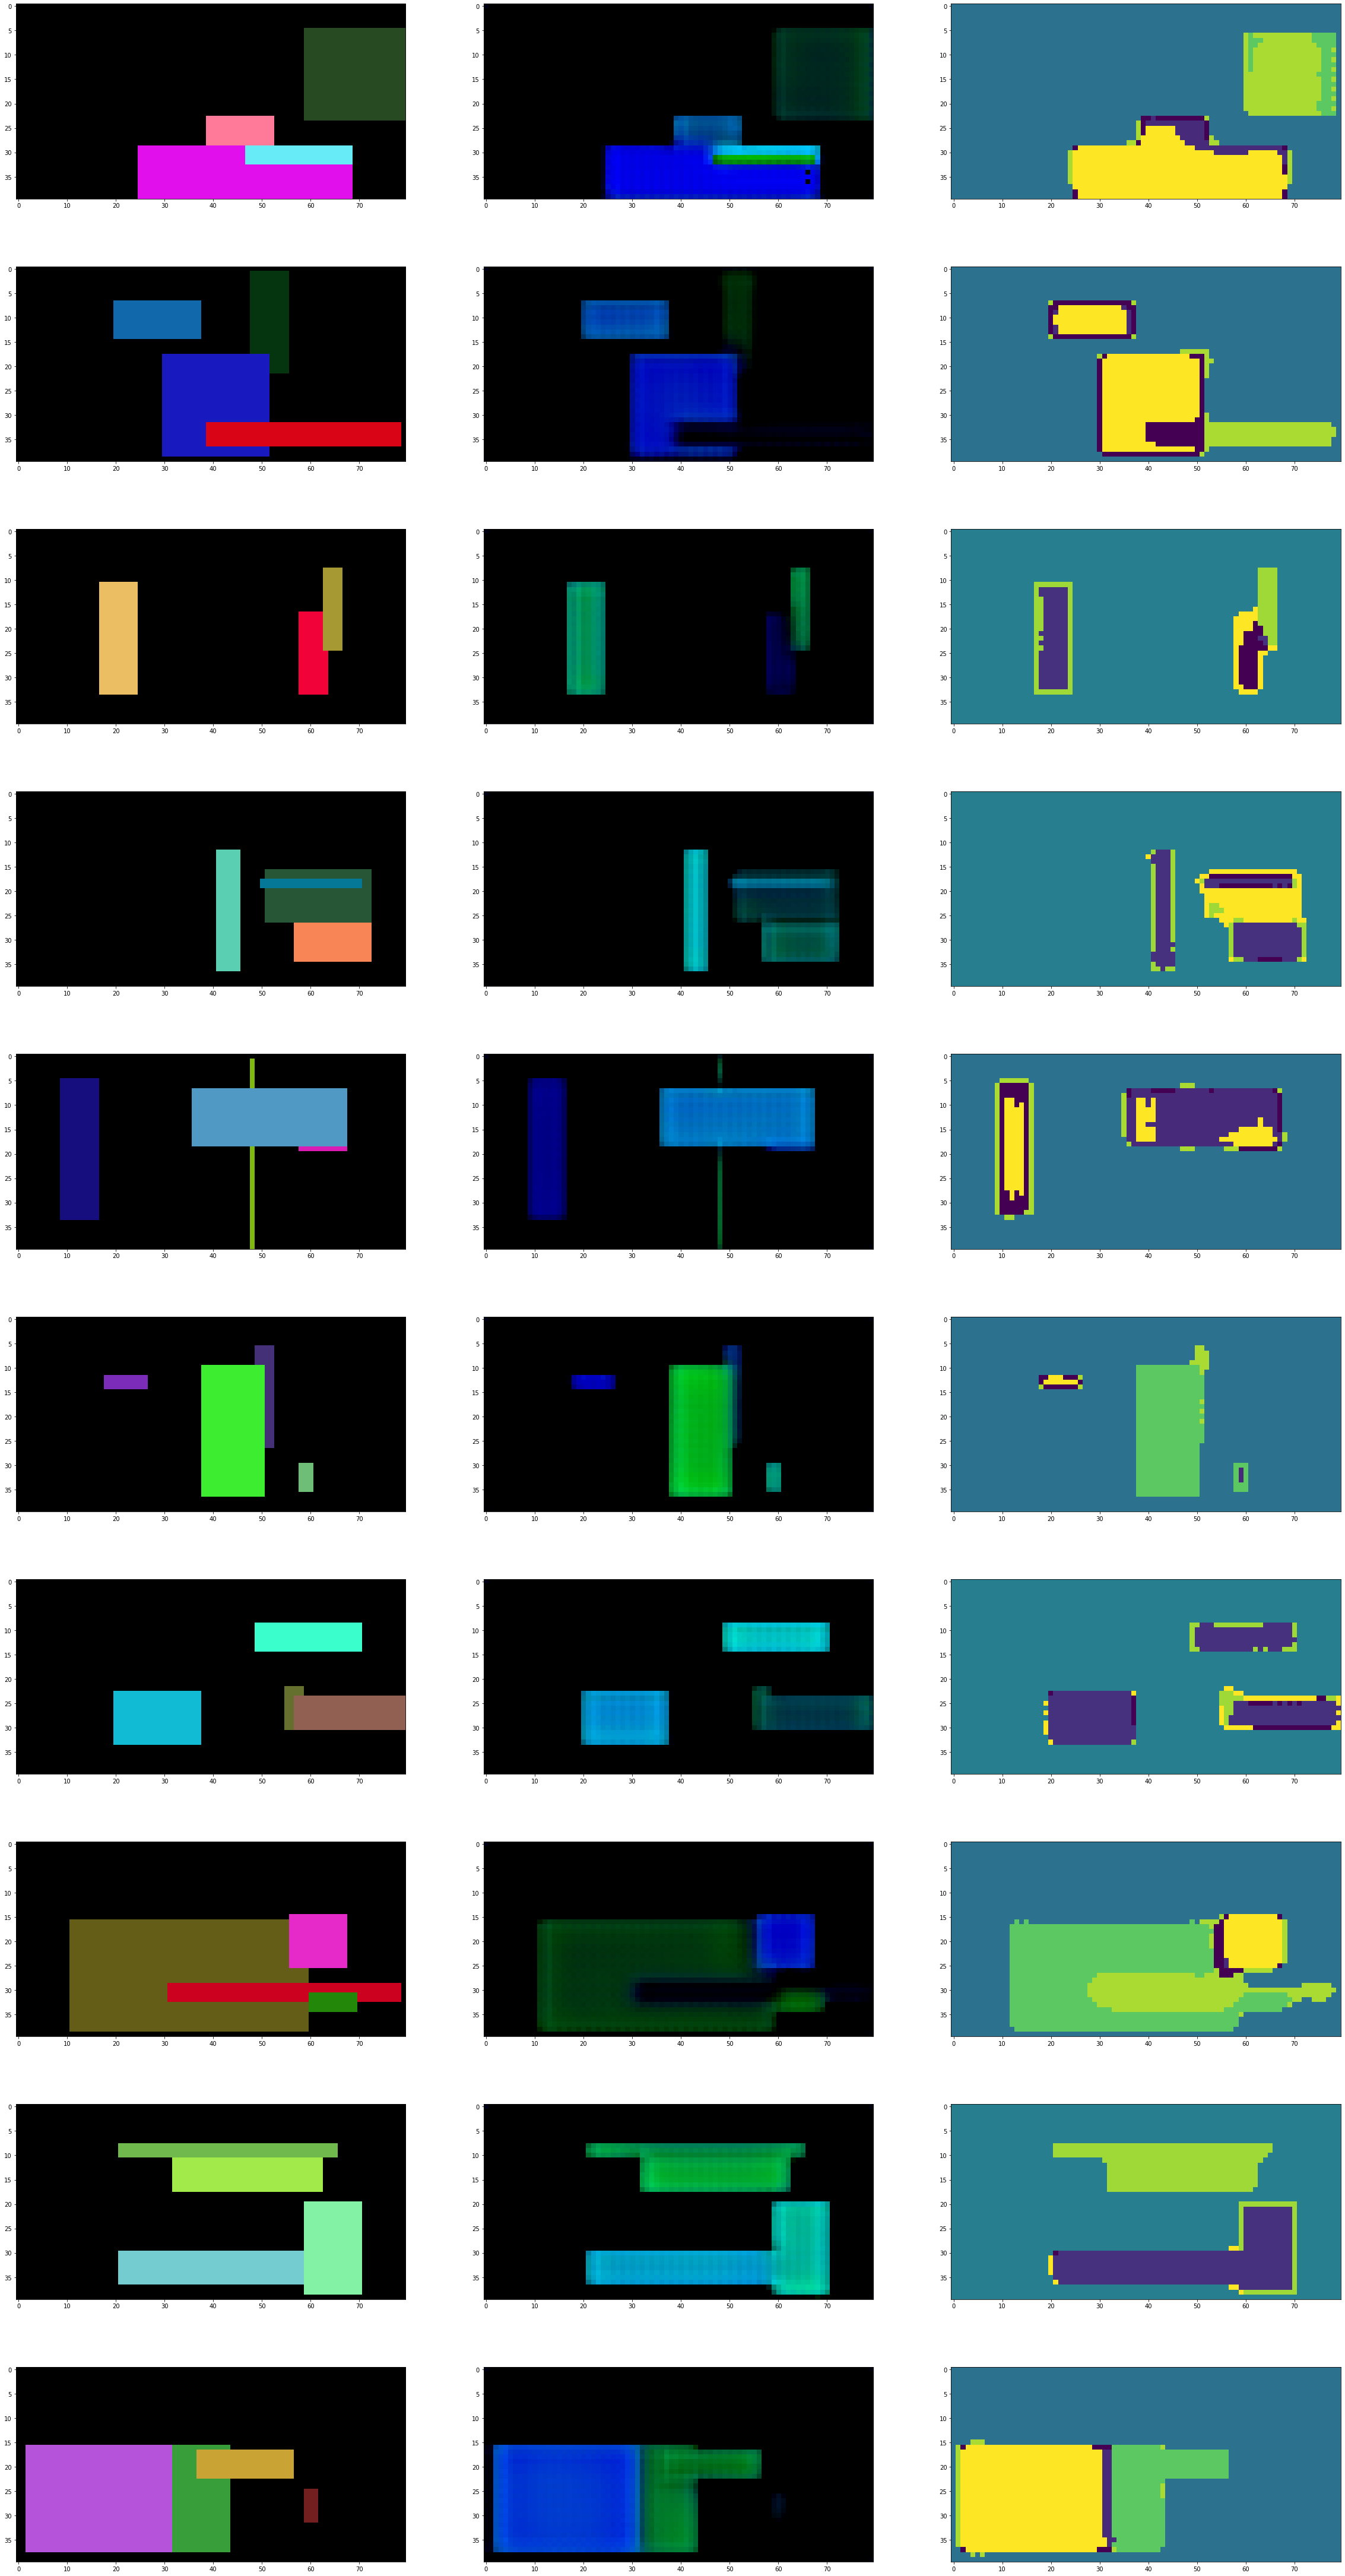

In [24]:
# show results

fig = plt.figure(figsize=(40,80))
columns = 3
rows = 10
for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows,columns,i*columns + j + 1)
        if j == 0:     
            plt.imshow(X_test[i,:,:,:])
        if j == 1:
            plt.imshow(recon_imgs[i])
        if j == 2:
            plt.imshow(arged_imgs[i])
    
plt.show()